In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if False:
  %cd /content/drive/MyDrive/ml-project-2-roadmen-bruv/
if False:
  %cd "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"
if True:
  # %cd "/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv"
  %cd "/content/drive/MyDrive/ml-project-2-roadmen-bruv"

/content/drive/.shortcut-targets-by-id/1Otvsxl8-1dcvf92GQ9nybOqsg4Z_dpEJ/ml-project-2-roadmen-bruv


## Libraries

In [4]:
from IPython.display import clear_output
!pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch
!pip install -U albumentations
clear_output()

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from helpers.mask_to_submission import masks_to_submission
from utils.data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset


# 0) Data aug

In [ ]:
 create_aug_data = False
 if create_aug_data:
  # Create folders for data augmentation
  %mkdir data/data_train_augmented
  %mkdir data/data_train_augmented/images/
  %mkdir data/data_train_augmented/masks/
  %mkdir data/data_train_augmented/raw/
  %mkdir data/data_train_augmented/raw/images/
  %mkdir data/data_train_augmented/raw/masks/
  %mkdir data/data_validation
  %mkdir data/data_validation/images/
  %mkdir data/data_validation/masks/
  %mkdir data/data_validation/raw/
  %mkdir data/data_validation/raw/images/
  %mkdir data/data_validation/raw/masks/

  # Load images and masks from dataset
  PATH_IMG_TRAIN = "./data/training/images/"
  PATH_MASK_TRAIN = "./data/training/groundtruth/"
  img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
  key_list = list(img_train.keys())
  key_list.sort()

  # Split the images for training/validation (+ store)
  training_ratio = 0.8
  seed = 1
  train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)

  PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
  PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
  PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
  PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"

  store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
  store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
  store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
  store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)

  MASK_THRESHOLD = 120
  SIZE_X = 416 #divisible by 32
  SIZE_Y = 416 #divisible by 32
  PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
  PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
  PATH_VAL_IMG = "./data/data_validation/images/"
  PATH_VAL_MASK = "./data/data_validation/masks/"

  # Load validation images and resize
  img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
  keys_val = list(img_val_raw.keys())
  resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)

  # Load training images, resize and augment using geometric transformation (+ store)
  img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
  keys_tr = list(img_tr_raw.keys())
  resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

# I) Model training

## Model choice

In [6]:
MODELS = ["Unet","DeepLabV3"] # Available : "Unet","DeepLabV3","FPN"
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
NB_EPOCHS = 20
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

## Dataset class definition

In [7]:
class Dataset(BaseDataset):
    CLASSES = ['road', 'unlabelled']

    def __init__(self, images_dir, masks_dir=None, classes=None, augmentation=None, preprocessing=None, plot = False):
        if masks_dir == None:
          self.ids = range(1, 51)
          self.images_fps = [os.path.join(images_dir, f'test_{idx}/',f'test_{idx}.png') for idx in self.ids]
        else:
          self.ids = os.listdir(images_dir)
          self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] if masks_dir is not None else None

        # convert str names to class values on masks
        if classes is not None:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        # self.preprocessing = None
        self.plot = plot

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        # initialize mask as None
        mask = None

        if self.masks_fps == None:
          print(self.images_fps[i])
          if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
          if self.preprocessing:
              sample = self.preprocessing(image=image)
              image = sample['image']
          return self.images_fps[i], image

        else:
          mask = cv2.imread(self.masks_fps[i], 0)
          mask = cv2.resize(mask, (416, 416))
          masks = [(mask == v) for v in self.class_values]
          mask = np.stack(masks, axis=-1).astype('float')
          if i == 0 and self.plot:
            plt_img_hist(image, mask)
            plt_img(image, mask)
          if self.augmentation:
              sample = self.augmentation(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']
          if i == 0 and self.plot:
            plt_img_hist(image, mask)
            plt_img(image, mask)
          if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
          if i == 0 and self.plot:
            plt_img_hist(image, mask)
            plt_img(image, mask)
          return image, mask

    def __len__(self):
        return len(self.ids)

## Model definitions

In [8]:
CLASSES = ['road']
DEVICE = 'cuda'

def deep_lab_v3_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE):
    model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    )
    return model

def unet_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE):
  model = smp.Unet(
  encoder_name=ENCODER,
  encoder_weights=ENCODER_WEIGHTS,
  classes=len(CLASSES),
  activation=ACTIVATION,
  )
  return model

def FPN_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE):
  model = smp.FPN(
  encoder_name=ENCODER,
  encoder_weights=ENCODER_WEIGHTS,
  classes=len(CLASSES),
  activation=ACTIVATION,
  )
  return model


# Dictionary mapping the string key to a function
model_functions = {
    'DeepLabV3': deep_lab_v3_function,
    'Unet': unet_function,
    'FPN': FPN_function
}

models = [[model_functions[model_name](ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE),model_name] for model_name in MODELS]

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 59.3MB/s]


## Data importation, preprocessing and evaluation metrics def

In [9]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [10]:
train_dataset = Dataset(
    "./data/data_train_augmented/images",
    "./data/data_train_augmented/masks",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset(
    "./data/data_validation/images",
    "./data/data_validation/masks",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)



### Integration of patch based evaluation methods

In [11]:
import torch.nn as nn
import segmentation_models_pytorch.utils.base as base
import segmentation_models_pytorch.utils.functional as F
from segmentation_models_pytorch.base.modules import Activation

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the image crop function
def img_crop(im, h, w):
    list_patches = []
    imgwidth = im.shape[2]
    imgheight = im.shape[3]
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im_patch = im[:, :, j:j+w, i:i+h]
            list_patches.append((im_patch, i, j))
    return list_patches

# Define the value to class conversion function
def value_to_class(v, threshold):
    v_mean = v.mean(dim=(2, 3))
    return (v_mean > threshold).float()

# Assuming predictions_tensor and ground_truths_tensor are the input 4D tensors
def patch_extraction(predictions_tensor, ground_truths_tensor, threshold_pred=0.4, threshold_gt=0.75, print = False):
    PATCH_SIZE = 16
    N, C, H, W = predictions_tensor.shape
    num_patches_height = H // PATCH_SIZE
    num_patches_width = W // PATCH_SIZE

    # Initialize tensors to hold the mean values
    predictions_means = torch.zeros((N, C, num_patches_height, num_patches_width))
    ground_truths_means = torch.zeros((N, C, num_patches_height, num_patches_width))

    # Crop the images into patches and compute the mean values
    predictions_patches = img_crop(predictions_tensor, PATCH_SIZE, PATCH_SIZE)
    ground_truths_patches = img_crop(ground_truths_tensor, PATCH_SIZE, PATCH_SIZE)

    # Assign the mean values to the correct location in the tensors
    for patch, i, j in predictions_patches:
        patch_idx_height = i // PATCH_SIZE
        patch_idx_width = j // PATCH_SIZE
        predictions_means[:, :, patch_idx_height, patch_idx_width] = patch.mean(dim=(2, 3))

    for patch, i, j in ground_truths_patches:
        patch_idx_height = i // PATCH_SIZE
        patch_idx_width = j // PATCH_SIZE
        ground_truths_means[:, :, patch_idx_height, patch_idx_width] = patch.mean(dim=(2, 3))

    # Apply threshold to determine class membership
    predictions_classes = (predictions_means > threshold_pred).float()
    ground_truths_classes = (ground_truths_means > threshold_gt).float()

    # Plot the mean images
    if print:
      fig, ax = plt.subplots(2, 2, figsize=(10, 5))
      ax[0, 0].imshow(predictions_means[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[0, 0].set_title('Predictions Mean Patch')
      ax[0, 1].imshow(ground_truths_means[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[0, 1].set_title('Ground Truths Mean Patch')
      ax[1, 0].imshow(predictions_classes[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[1, 0].set_title('predictions_classes')
      ax[1, 1].imshow(ground_truths_classes[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[1, 1].set_title('ground_truths_classes')
      plt.show()

      # Plot histograms
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.hist(predictions_means[0].squeeze().detach().numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Prediction Means')
      plt.title('Histogram of Prediction Means')
      plt.xlabel('Pixel Values')
      plt.ylabel('Frequency')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.hist(ground_truths_means[0].squeeze().detach().numpy().flatten(), bins=50, color='green', alpha=0.7, label='Ground Truth Means')
      plt.title('Histogram of Ground Truth Means')
      plt.xlabel('Pixel Values')
      plt.ylabel('Frequency')
      plt.legend()

      plt.tight_layout()
      plt.show()

    return predictions_classes, ground_truths_classes

In [13]:
## Composite metrics
def Custom_iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = F._threshold(pr, threshold=threshold)
    pr, gt = F._take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union

def Custom_f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None, w_pix = 1, w_patch = 1):

  pr_pix = pr
  gt_pix = gt
  pr_patch, gt_patch = patch_extraction(pr, gt)

  f_score_pix = F.f_score(
            pr_pix,
            gt_pix,
            beta= beta,
            eps= eps,
            threshold=None,
            ignore_channels=ignore_channels,)
  f_score_patch = F.f_score(
            pr_patch,
            gt_patch,
            beta= beta,
            eps= eps,
            threshold=None,
            ignore_channels=ignore_channels,)

  return (w_pix * f_score_pix + w_patch * f_score_patch) / (w_pix + w_patch)


In [14]:
## Composite loss function:
# class DiceLoss(base.Loss):
#     def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
#         super().__init__(**kwargs)
#         self.eps = eps
#         self.beta = beta
#         self.activation = Activation(activation)
#         self.ignore_channels = ignore_channels

#     def forward(self, y_pr, y_gt):
#         y_pr = self.activation(y_pr)
#         return 1 - F.f_score(
#             y_pr,
#             y_gt,
#             beta=self.beta,
#             eps=self.eps,
#             threshold=None,
#             ignore_channels=self.ignore_channels,
#         )

class CustomDiceLoss(base.Loss):
  def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, w_pix = 1, w_patch = 0, **kwargs):
      super().__init__(**kwargs)
      self.eps = eps
      self.beta = beta
      self.activation = Activation(activation)
      self.ignore_channels = ignore_channels
      self.w_pix = w_pix
      self.w_patch = w_patch

  def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        threshold = None
        return 1 - Custom_f_score(y_pr,
                                  y_gt,
                                  beta=self.beta,
                                  eps=self.eps,
                                  threshold=None,
                                  ignore_channels=self.ignore_channels,
                                  w_pix = self.w_pix,
                                  w_patch = self.w_patch)



In [15]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.DiceLoss()
# metrics = [
#     smp.utils.metrics.IoU(threshold=0.5),
#     smp.utils.metrics.Fscore(),
# ]
loss = CustomDiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
    ]

## Visualizing pre-processed data

A la base, utile si on train juste le decoder, pas tout le modèle, mais on train tout le modèle. Vérifier si véritablement meilleure convergence?

In the code snippet you provided, the optimizer is set up to update parameters for the entire model, not just the decoder. This is indicated by the line:

```
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])\
```



Here, model.parameters() refers to all the parameters of the model that will be updated during training. If only the decoder was being trained, the parameters would need to be specifically filtered to only include those of the decoder.

In [16]:
# Get the first image and its mask from the dataset.
image, mask = train_dataset[0]

In [17]:
def plt_img_hist(image, mask):
    # Set up the matplotlib figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the histogram for the image
    axs[0].hist(image.flatten(), bins=30, edgecolor='black', color='blue')
    axs[0].set_title('Image Histogram')
    axs[0].set_xlabel('Pixel Intensity')
    axs[0].set_ylabel('Frequency')

    # Plot the histogram for the mask
    axs[1].hist(mask.flatten(), bins=30, edgecolor='black', color='green')
    axs[1].set_title('Mask Histogram')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()


In [18]:
def plt_img(image, mask):
    # Print the original dimensions
    print(f"Original image dimensions: {image.shape}")
    print(f"Original mask dimensions: {mask.shape}")

    # Plotting the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Only transpose the image if it's not in the (height, width, channels) format
    if image.ndim == 3 and image.shape[-1] != 3:
        image = image.transpose((1, 2, 0))  # Reorder dimensions to (height, width, channels)
        print(f"Transposed image dimensions: {image.shape}")

    # Only squeeze the mask if it's a 3D array with a single channel
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)  # Remove the singular first dimension
        print(f"Squeezed mask dimensions: {mask.shape}")

    # Image
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    # Mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()


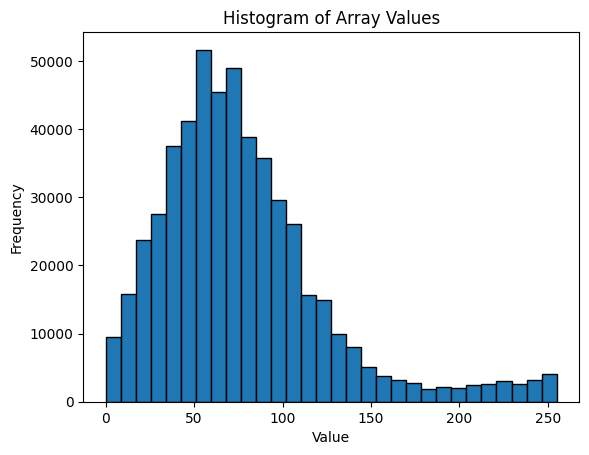

In [19]:
# Plot the histogram
plt.hist(image.flatten(), bins=30, edgecolor='black')

# Add title and labels
plt.title('Histogram of Array Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [20]:
def plt_img(image, mask):
  # Plotting the image and mask
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  image = image.transpose((1, 2, 0))  # Reorder dimensions to (height, width, channels)
  mask = mask.transpose((1, 2, 0))  # Reorder dimensions to (height, width, channels)
  # Image
  ax[0].imshow(image)
  ax[0].set_title('Image')
  ax[0].axis('off')

  # Mask
  ax[1].imshow(mask, cmap='gray')
  ax[1].set_title('Mask')
  ax[1].axis('off')

  plt.show()


## Training

In [ ]:
# train model for NB_EPOCHS
only_one = False

for model,model_name in models:
  print(model_name)
  optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss,
      metrics=metrics,
      optimizer=optimizer,
      device=DEVICE,
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss,
      metrics=metrics,
      device=DEVICE,
      verbose=True,
  )


  max_score = 0
  train_loss_array = []
  validation_loss_array = []
  validation_fscore_array = []



  for i in range(0, NB_EPOCHS):

      print('\nEpoch: {}'.format(i))
      train_logs = train_epoch.run(train_loader)
      valid_logs = valid_epoch.run(valid_loader)
      print(train_logs)
      print(valid_logs)
      train_loss_array.append(train_logs["custom_dice_loss"])
      validation_loss_array.append(valid_logs["custom_dice_loss"])
      validation_fscore_array.append(valid_logs["fscore"])
      print(valid_logs)
      # do something (save model, change lr, etc.)
      if max_score < valid_logs['iou_score']:
          max_score = valid_logs['iou_score']
          torch.save(model, './submissions/models/best_model_alt_loss_{}.pth'.format(model_name))
          print('Model saved!')

      if i == 25:
          optimizer.param_groups[0]['lr'] = 1e-5
          print('Decrease decoder learning rate to 1e-5!')
  if only_one:
    break
  epochs = range(0,len(train_loss_array))

# test_model = model
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_array,"o", label='Training Loss')
plt.plot(epochs, validation_loss_array,  label='Validation Loss')
plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
plt.title('Training and Validation Loss for {}'.format(model_name))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Unet

Epoch: 0
valid: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, custom_dice_loss - 0.1087, iou_score - 0.8946, fscore - 0.9432]
{'custom_dice_loss': 0.16413868914047883, 'iou_score': 0.7889887953797972, 'fscore': 0.8714657155176005}
{'custom_dice_loss': 0.10873166024684906, 'iou_score': 0.8945982813835144, 'fscore': 0.943210718035698}
{'custom_dice_loss': 0.10873166024684906, 'iou_score': 0.8945982813835144, 'fscore': 0.943210718035698}
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s, custom_dice_loss - 0.08181, iou_score - 0.914, fscore - 0.9541]
{'custom_dice_loss': 0.08280198474725088, 'iou_score': 0.9323767284552256, 'fscore': 0.9649560903509458}
{'custom_dice_loss': 0.08180935084819793, 'iou_score': 0.9140419781208039, 'fscore': 0.9540618389844894}
{'custom_dice_loss': 0.08180935084819793, 'iou_score': 0.9140419781208039, 'fscore': 0.9540618389844894}
Model saved!

Epoch: 2
valid: 100%|██████████| 20/20 [00:03<00:00,  6.16it/s, custom_dice_loss -

KeyboardInterrupt: ignored

# II) Visualization & Submission

In [ ]:
# Instantiate your model
# IF YOU TRAINED IT ON GPU, HAS TO BE LOADED ON GPU
gpu = True
cpu = False
MODEL_PATH = "submissions/models/best_model_alt_loss_Unet.pth"
if gpu:
  DEVICE = 'cuda'
  # model = FPN_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE)
  # state_dict = torch.load(MODEL_PATH)
  test_model = torch.load(MODEL_PATH)
if cpu:
  DEVICE = 'cpu'
  model = FPN_function(ENCODER, ENCODER_WEIGHTS, CLASSES, ACTIVATION, DEVICE)
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# model.load_state_dict(state_dict)

# Put the model in evaluation mode
test_model.eval()

### Test

In [22]:
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


### Visualization

In [23]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Assuming 2 is an instance of DataLoader using the Dataset class without masks
batch = next(iter(test_loader))
with torch.no_grad():
    test_model = test_model.to(DEVICE)
    test_model.eval()
    logits = test_model(batch[1].to(DEVICE))  # Ensure you move your inputs to the device where your model is
    pr_gts = logits.sigmoid()

for img_fp, pr_gt in zip(batch, pr_gts):
    img_fp = img_fp[0]
    print(img_fp)
    img = cv2.imread(img_fp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (416, 416))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
    plt.title("Image")
    plt.axis("off")
    # Plot a histogram of pixel values
    plt.subplot(1, 3, 2)
    plt.hist(pr_gt.cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Pixel Values')
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Values')
    plt.ylabel('Frequency')
    # Convert the GPU tensor to CPU and then to a NumPy array before displaying
    plt.subplot(1, 3, 3)
    pr_gt_cpu = pr_gt.cpu().numpy().squeeze()  # Move to CPU and convert to NumPy
    pr_gt_cpu[pr_gt_cpu >= 0.6] = 1
    pr_gt_cpu[pr_gt_cpu < 0.6] = 0
    plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
    plt.title("Prediction")
    plt.axis("off")


    plt.show()


./data/test_set_images/test_1/test_1.png


RuntimeError: ignored

./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_1/test_1.png


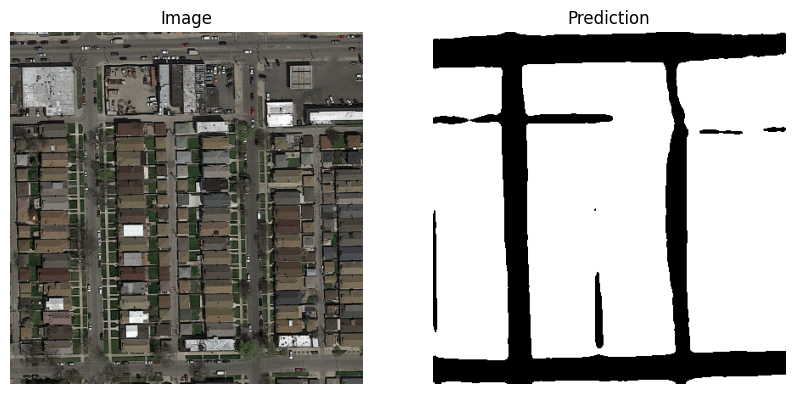

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Assuming 2 is an instance of DataLoader using the Dataset class without masks
batch = next(iter(test_loader))
with torch.no_grad():
    test_model = test_model.to(DEVICE)
    test_model.eval()
    logits = test_model(batch[1].to(DEVICE))  # Ensure you move your inputs to the device where your model is
    pr_gts = logits.sigmoid()

for img_fp, pr_gt in zip(batch, pr_gts):
    img_fp = img_fp[0]
    print(img_fp)
    img = cv2.imread(img_fp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (416, 416))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
    plt.title("Image")
    plt.axis("off")

    # Convert the GPU tensor to CPU and then to a NumPy array before displaying
    plt.subplot(1, 2, 2)
    pr_gt_cpu = pr_gt.cpu().numpy().squeeze()  # Move to CPU and convert to NumPy
    pr_gt_cpu[pr_gt_cpu >= 0.6] = 1
    pr_gt_cpu[pr_gt_cpu < 0.6] = 0
    plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
    plt.title("Prediction")
    plt.axis("off")

    plt.show()


./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_1/test_1.png


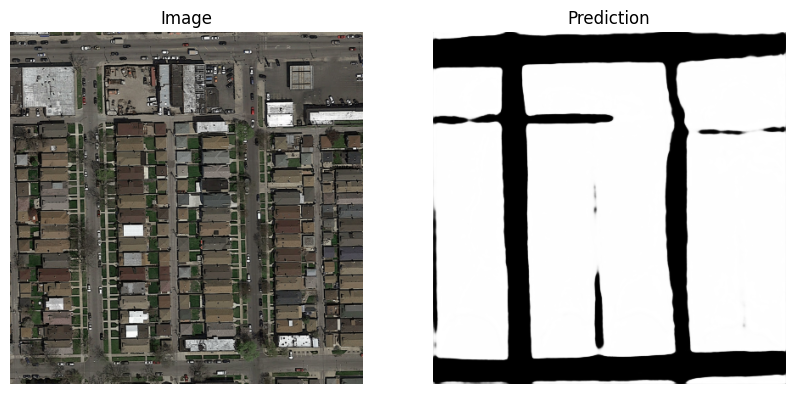

./data/test_set_images/test_2/test_2.png
./data/test_set_images/test_2/test_2.png


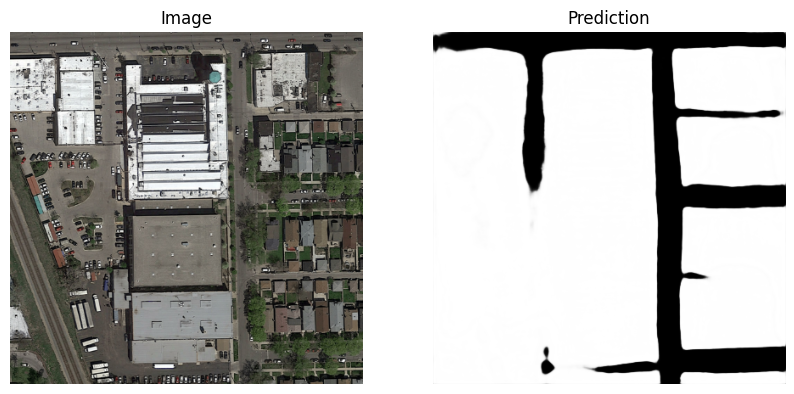

./data/test_set_images/test_3/test_3.png
./data/test_set_images/test_3/test_3.png


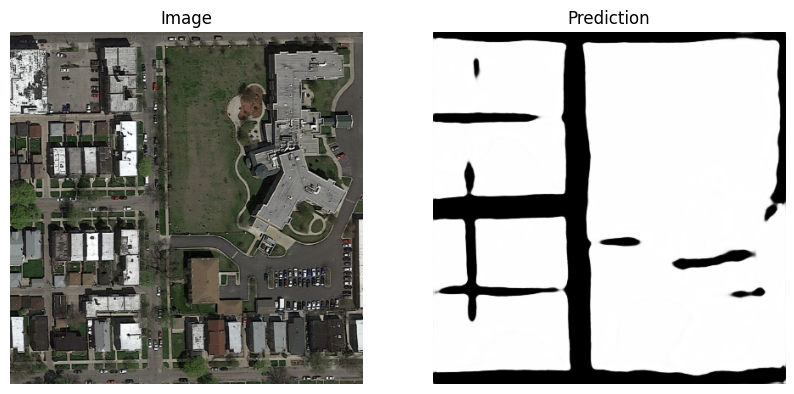

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Ensure the model is on the correct device and in evaluation mode
test_model = test_model.to(DEVICE)
test_model.eval()
img_nbr = 3
i = 0
# Iterate over all batches in the test_loader
for batch in test_loader:
    i += 1
    with torch.no_grad():
        # Move input to the device where the model is
        input_tensors = batch[1].to(DEVICE)
        logits = test_model(input_tensors)
        pr_gts = logits.sigmoid()

        # Since there are no ground truth masks, we only visualize the images and predictions
        for img_fp, pr_gt in zip(batch[0], pr_gts):  # batch[0] should contain the file paths
            print(img_fp)
            img = cv2.imread(img_fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (416, 416))

            # Get the prediction as a numpy array
            pr_gt_np = pr_gt.cpu().numpy().squeeze()

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(pr_gt_np, cmap='gray')  # Show the prediction
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
    if i == img_nbr:
      break


### .csv File

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)
foreground_threshold = 0.6  # Threshold for determining foreground vs background

# Parameters for saving images
output_folder = './submissions/submission_test_new_loss/eval_imgs/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over the DataLoader
for i, (path, image) in enumerate(test_loader):
    # print("Processing image:", i)
    path = path[0]
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        logits = test_model(input_tensor)
        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(logits)
        # Squeeze to remove unnecessary dimensions
        probabilities = probabilities.squeeze(0).squeeze(0)
        # Apply threshold to the probabilities to binarize
        prediction_binarized = (probabilities < foreground_threshold).float()

        # Convert the binarized prediction to a PIL image
        prediction_pil = to_pil_image(prediction_binarized)

        # Resize the PIL image to 608x608
        prediction_pil_resized = prediction_pil.resize((608, 608), Image.NEAREST)

        # Save the image
        image_num = path.split('/')[-1].split('_')[-1].split('.')[0]
        image_num = int(image_num)
        filename = "test_eval_" + '%.3d' % image_num + '.png'
        prediction_pil_resized.save(os.path.join(output_folder, filename))
        # print(f"Saved {filename}")


./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_2/test_2.png
./data/test_set_images/test_3/test_3.png
./data/test_set_images/test_4/test_4.png
./data/test_set_images/test_5/test_5.png
./data/test_set_images/test_6/test_6.png
./data/test_set_images/test_7/test_7.png
./data/test_set_images/test_8/test_8.png
./data/test_set_images/test_9/test_9.png
./data/test_set_images/test_10/test_10.png
./data/test_set_images/test_11/test_11.png
./data/test_set_images/test_12/test_12.png
./data/test_set_images/test_13/test_13.png
./data/test_set_images/test_14/test_14.png
./data/test_set_images/test_15/test_15.png
./data/test_set_images/test_16/test_16.png
./data/test_set_images/test_17/test_17.png
./data/test_set_images/test_18/test_18.png
./data/test_set_images/test_19/test_19.png
./data/test_set_images/test_20/test_20.png
./data/test_set_images/test_21/test_21.png
./data/test_set_images/test_22/test_22.png
./data/test_set_images/test_23/test_23.png
./data/test_set_images/test_2

In [ ]:
SUBMISSION_PATH = "./submissions/submission_test_new_loss/"
submission_filename = SUBMISSION_PATH + 'test_submission.csv'
image_filenames = []
for i in range(1, 51):
    # image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filename = SUBMISSION_PATH + 'eval_imgs/test_eval_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)


./submissions/submission_test_new_loss/eval_imgs/test_eval_001.png
001
./submissions/submission_test_new_loss/eval_imgs/test_eval_002.png
002
./submissions/submission_test_new_loss/eval_imgs/test_eval_003.png
003
./submissions/submission_test_new_loss/eval_imgs/test_eval_004.png
004
./submissions/submission_test_new_loss/eval_imgs/test_eval_005.png
005
./submissions/submission_test_new_loss/eval_imgs/test_eval_006.png
006
./submissions/submission_test_new_loss/eval_imgs/test_eval_007.png
007
./submissions/submission_test_new_loss/eval_imgs/test_eval_008.png
008
./submissions/submission_test_new_loss/eval_imgs/test_eval_009.png
009
./submissions/submission_test_new_loss/eval_imgs/test_eval_010.png
010
./submissions/submission_test_new_loss/eval_imgs/test_eval_011.png
011
./submissions/submission_test_new_loss/eval_imgs/test_eval_012.png
012
./submissions/submission_test_new_loss/eval_imgs/test_eval_013.png
013
./submissions/submission_test_new_loss/eval_imgs/test_eval_014.png
014
./subm